# TRY data preprocessing

## Content

The TRY database contains trait measurements from individual plants and, typically, multiple individual measurements per trait and species. Before linking the data with the GBIF data, we want a mean trait value per species.

This section covers:

- Download TRY Data
- Load data
- clean data
- Fuzzy Aggregation of species names
- Mean trait measurement per species

## Assignemnts
- Run the fuzzy matching and calculate how many additional observations we gain from that.

## Packages, etc.

In [3]:
import pandas as pd # dataframes
import numpy as np  
import os # system interface
import matplotlib.pyplot as plt # plotting
from rapidfuzz import process, fuzz
import os

In [4]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Download TRY Data

To download data from the TRY database, create an account at https://www.try-db.org/de.

We choose the option of open access data only, but the curators of this database still require you to add a short project description to your download request. You will then be sent a download link via e-mail.

For this study we will use continuous (con) traits used in the analysis from Diaz et al. 2016:


## Traits in TRY gap-filled:
| TRY trait ID | Trait name |
|--------------|------------|
| 4            | Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume) |
| 6            | Root rooting depth |
| 11           | Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA) |
| 13           | Leaf carbon (C) content per leaf dry mass |
| 14           | Leaf nitrogen (N) content per leaf dry mass |
| 15           | Leaf phosphorus (P) content per leaf dry mass |
| 18           | Plant height |
| 21           | Stem diameter |
| 26           | Seed dry mass |
| 27           | Seed length |
| 46           | Leaf thickness |
| 47           | Leaf dry mass per leaf fresh mass (leaf dry matter content, LDMC) |
| 50           | Leaf nitrogen (N) content per leaf area |
| 55           | Leaf dry mass (single leaf) |
| 78           | Leaf nitrogen (N) isotope signature (delta 15N) |
| 95           | Seed germination rate (germination efficiency) |
| 138          | Seed number per reproduction unit |
| 144          | Leaf length |
| 145          | Leaf width |
| 146          | Leaf carbon/nitrogen (C/N) ratio |
| 163          | Leaf fresh mass |
| 169          | Stem conduit density (vessels and tracheids) |
| 223          | Species genotype: chromosome number |
| 224          | Species genotype: chromosome cDNA content |
| 237          | Dispersal unit length |
| 281          | Stem conduit diameter (vessels, tracheids) |
| 282          | Wood vessel element length; stem conduit (vessel and tracheids) element length |
| 289          | Wood fiber lengths |
| 1080         | Root length per root dry mass (specific root length, SRL) |
| 3112         | Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded) |
| 3113         | Leaf area (in case of compound leaves: leaflet, undefined if petiole is in- or excluded) |
| 3114         | Leaf area (in case of compound leaves: undefined if leaf or leaflet, undefined if petiole is in- or excluded) |
| 3120         | Leaf water content per leaf dry mass (not saturated) |

## Load TRY data

First, load the TRY data as a data frame:

In [19]:
TRYdata = pd.read_csv("data/TRY_5_gapfilled/TRY_50_2020_01/gapfilled_data/mean_gap_filled_back_transformed_incl_species_names.csv", sep = ",", encoding="iso-8859-1")

In [20]:
TRYdata.head()

,Unnamed: 0,ObservationID,Species,Genus,Family,Unnamed: 5,X4,X6,X11,X13,...,X224,X237,X281,X282,X289,X1080,X3112,X3113,X3114,X3120
0,1,15472,Acer campestre,Acer,Sapindaceae,1,0.575278,1.591828,16.555035,467.432582,...,1.912803,11.633834,18.572872,281.066851,602.987635,2125.125411,1744.813490,1814.698241,1986.123466,3.378113
1,2,15473,Acer platanoides,Acer,Sapindaceae,2,0.578694,2.684251,18.025933,478.993421,...,1.926785,22.069494,28.253946,244.409216,465.283791,2281.846496,8020.967391,6930.279638,9414.095662,2.844882
2,3,15474,Acer pseudoplatanus,Acer,Sapindaceae,3,0.565983,3.626007,14.525270,465.678355,...,1.926318,17.481870,35.892412,269.923990,625.571232,2912.703245,6559.387661,7161.510957,7258.748497,3.102016
3,4,15475,Aesculus hippocastanum,Aesculus,Sapindaceae,4,0.512497,1.294184,13.685400,476.455478,...,1.051404,36.273125,149.464337,1912.797150,1978.554979,222.062770,34646.499320,7422.981332,19558.197900,3.360854
4,5,15476,Alnus glutinosa,Alnus,Betulaceae,5,0.472010,0.650320,15.543528,477.811755,...,1.327681,2.429191,33.449572,370.340169,576.379892,2939.846214,2572.873819,2843.044898,2723.491784,3.424225


Each row represents one trait measurements performed on one individual plant. To get an idea of the data, look at the shape of the dataframe. We then remove the observations that do not have measurements for out traits of interest, i.e. the ```trait ID``` is ```NaN```.

In [21]:
TRYdata.shape

(609355, 39)

In [22]:
# number of unique species
TRYdata["Species"].nunique()

52104

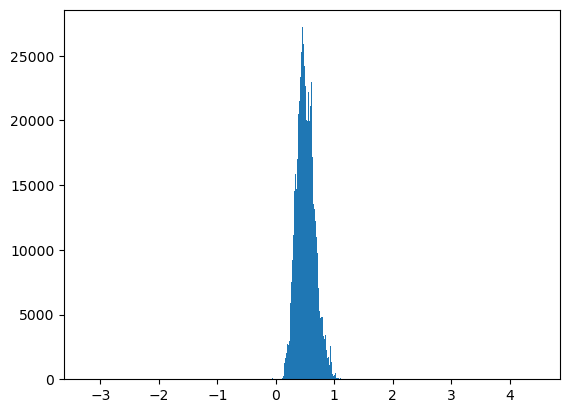

In [23]:
plt.hist(TRYdata["X4"], bins = 500)
plt.show()

It seems that there are some outliers in the data. Let's remove them before plotting.

(0.130532604212, 1.082549426110012)

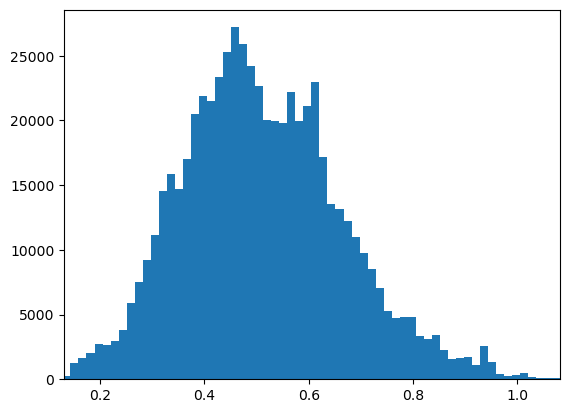

In [24]:
plt.hist(TRYdata["X4"], bins = 500)
plt.xlim(TRYdata["X4"].quantile(0.001), TRYdata["X4"].quantile(0.999))

Lets remove the outliers of all columns

In [25]:
# replace with your actual column names

columns = [element for element in TRYdata.columns if "X" in element]

# Filter data by quantile range for each column
for col in columns:
    # Calculate lower and upper quantiles for each column
    lower_quantile = TRYdata[col].quantile(0.001)
    upper_quantile = TRYdata[col].quantile(0.999)

    # Filter data by quantile range for each column
    TRYdata = TRYdata[(TRYdata[col] >= lower_quantile) & (TRYdata[col] <= upper_quantile)]

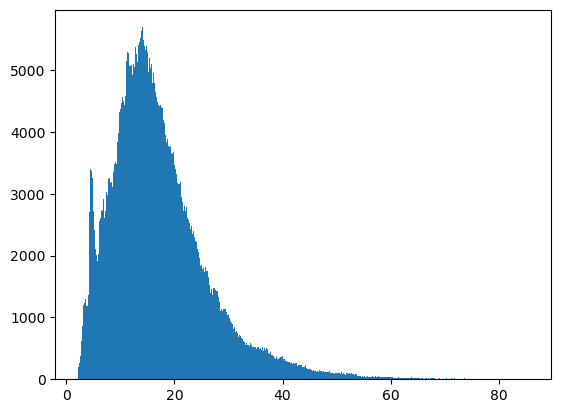

In [26]:
plt.hist(TRYdata["X11"], bins = 500)
plt.show()

## Fuzzy Aggregation of species names (optional)

Are there duplicates in the TRY species names? Later, for merging species with the GBIF data, we only need a unique name (string) per species. However, typos, author synonyms or minor differences in spelling result in multiple, very similar text strings that eventually refer to the same species.

We therefore remove author annotation from species names, since the data we want to later merge TRY data with - iNaturalist, observations - only have species names without author annotations. 

In [27]:
TRYdata["Species"]

0                 Acer campestre
1               Acer platanoides
2            Acer pseudoplatanus
3         Aesculus hippocastanum
4                Alnus glutinosa
                   ...          
609349         Polygala amarella
609351           Juncus tenageia
609352           Juncus tenageia
609353           Juncus tenageia
609354           Juncus tenageia
Name: Species, Length: 570382, dtype: object

In [14]:
# make all letters lower case
TRYdata['Species'] = TRYdata['Species'].str.lower()
# capitalize first letter in string
TRYdata['Species'] = TRYdata['Species'].str.capitalize()
# get only two first words (split at space)
TRYdata['Species']  = TRYdata['Species'].apply(lambda x: ' '.join(x.split()[0:2]))
# change type to string
TRYdata['Species'] = TRYdata['Species'].astype(str)

Unique species:

In [15]:
TRY_sp = TRYdata["Species"].apply(str)
TRY_sp = TRY_sp.unique()

In [16]:
len(TRY_sp)

49572

Moreover, we use fuzzy matching to identify similar species names in the TRY dataset. We use the rapidfuzz library to calculate the similarity between species names.

In [17]:
def fuzzy_match(choices, queries, cutoff):
    
    score_sort = [(x,) + i
             for x in queries
             for i in process.extract(x, choices, score_cutoff=cutoff, scorer=fuzz.token_sort_ratio) ]
    
    similarity_sort = pd.DataFrame(score_sort)
    similarity_sort = similarity_sort[similarity_sort[2] != 100.0]
    return similarity_sort

In [20]:
TRY_matches = fuzzy_match(TRY_sp, TRY_sp, 95)

KeyboardInterrupt: 

In [21]:
TRY_matches.head()

NameError: name 'TRY_matches' is not defined

In [ ]:
TRY_matches[0].nunique()

516

Only 0.5% of unique species in TRY have potential duplicates (similar names). We decided to diregard this slight uncertainty and accepted that these species might not be matched to the iNaturalist observations.

We devide the number for matches by 2, since every pair is listed twice (positions switched).

In [ ]:
(len(TRY_matches)/2)/len(TRY_sp)

0.005124450951683748

## Mean trait measurement per species

Here we create a dataframe with one species per row with a mean trait value and standard deviations for each trait in the following columns.

Number of unique species:

In [28]:
TRYdata['Species'].nunique()

49617

### Create summary stats with consolidated species name

Use ```groupby``` function to group data by consolidated species name and trait; grouping variables: ```AccSpeciesName, TraitName, TraitID```.

More information: https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm

In [29]:
columns = [element for element in TRYdata.columns if "X" in element]
TRYgroup = TRYdata.groupby('Species')[columns].agg(["mean"]).reset_index() # use reset index to keep the column used for grouping as column name and not as index
# (we could also calculate the standard deviation (std) and other statistical moments ... could be interesting for some research questions)

In [30]:
TRYgroup.head()

,Species,X4,X6,X11,X13,X14,X15,X18,X21,X26,...,X224,X237,X281,X282,X289,X1080,X3112,X3113,X3114,X3120
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,ABACABA (PALM),0.671823,2.188646,13.752224,474.569278,25.325213,1.253182,8.429638,0.231325,46.814951,...,2.479627,5.936477,38.547778,286.838857,806.185129,1540.977178,1629.962999,991.632159,1292.580095,2.645555
1,ABIU CASCA,0.496978,0.895004,6.247421,500.148092,12.696800,1.144893,13.550313,0.381413,17.222438,...,30.945200,11.971509,12.890332,790.671776,1499.280739,1884.325418,127.191046,164.447038,134.333586,2.325147
2,ABIU CUTITI,0.477223,0.944608,6.634051,497.942213,11.877977,1.194187,13.245605,0.157332,15.917046,...,28.611930,11.138268,14.919169,777.428052,1436.118489,2397.983455,126.666144,179.955887,155.449882,2.269552
3,ABIU PITOMBA,0.526880,1.117702,6.008566,499.808617,12.514770,1.147831,14.294867,0.708226,17.327678,...,28.940369,12.007877,12.938410,819.450661,1483.106728,1452.674352,121.175669,165.365746,129.872318,2.173392
4,ACAENA NOVAE-ZELANDIAE,0.604919,0.061492,19.541665,463.533962,22.480895,1.573733,0.148318,0.016437,1.394972,...,0.842433,2.766139,36.771047,492.019265,639.806141,2438.558694,634.997968,480.992218,673.851300,3.033819


Lets see if the aggregation worked:

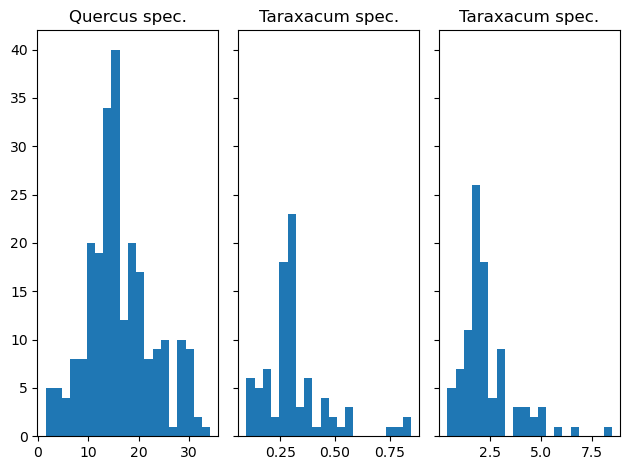

In [31]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(TRYgroup.loc[TRYgroup['Species'].str.contains('Quercus'), ('X18',"mean")], bins = 20)
axs[0].set_title('Quercus spec.')

axs[2].hist(TRYgroup.loc[TRYgroup['Species'].str.contains('Rosa'), ('X18',"mean")], bins = 20)
axs[2].set_title('Taraxacum spec.')

axs[1].hist(TRYgroup.loc[TRYgroup['Species'].str.contains('Poa'), ('X18',"mean")], bins = 20)
axs[1].set_title('Taraxacum spec.')

plt.show()

In [32]:
def shorten_names(df):
    rename_dict = {
        'X4': 'Stem specific density (SSD)',
        'X13': 'Leaf carbon (C) per mass',
        'X14': 'Leaf nitrogen (N) per mass',
        'X15': 'Leaf phosphorus (P) per mass',
        'X47': 'Leaf dry mass per leaf fresh mass (LDMC)',
        'X26': 'Seed mass',
        'X27': 'Seed length',
        'X50': 'Leaf nitrogen (N) per area',
        'X65': 'Leaf nitrogen/phosphorus (N/P)',
        'X78': 'Leaf delta15N',
        'X163': 'Leaf fresh mass',
        'X138': 'Seeds per rep. unit',
        'X169': 'Stem conduit density',
        'X237': 'Dispersal unit length',
        'X282': 'Conduit element length',
        'X18': 'Plant Height',
        'X3113': 'Leaf Area (leaf, petiole undef.)',
        'X3112': 'Leaf Area (leaflet, petiole undef.)',
        'X11': 'Specific Leaf Area (SLA)',
        'X3114': 'Leaf Area (all undefined)',
        'X6': 'Root rooting depth',
        'X1080': 'Root length per root dry mass',
        'X3120': 'Leaf Water content per mass',
        'X21': 'Seed diameter',
        'X46': 'Leaf thickness',
        'X55': 'Leaf dry mass per leaf',
        'X95': 'Seed germination rate',
        'X144': 'Leaf length',
        'X145': 'Leaf width',
        'X146': 'Leaf carbon/nitrogen (C/N) ratio',
        'X223': 'chromosome number',
        'X224': 'chromosome cDNA content',
        'X281': 'Stem conduit diameter',
        'X289': 'Wood fibre length'
    }

    df.rename(columns=rename_dict, inplace=True)

In [33]:
shorten_names(TRYgroup)

In [34]:
# Assuming 'df' is your DataFrame

with pd.option_context('display.max_columns', None):
    display(TRYgroup.head())

,Species,Stem specific density (SSD),Root rooting depth,Specific Leaf Area (SLA),Leaf carbon (C) per mass,Leaf nitrogen (N) per mass,Leaf phosphorus (P) per mass,Plant Height,Seed diameter,Seed mass,Seed length,Leaf thickness,Leaf dry mass per leaf fresh mass (LDMC),Leaf nitrogen (N) per area,Leaf dry mass per leaf,Leaf delta15N,Seed germination rate,Seeds per rep. unit,Leaf length,Leaf width,Leaf carbon/nitrogen (C/N) ratio,Leaf fresh mass,Stem conduit density,chromosome number,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,ABACABA (PALM),0.671823,2.188646,13.752224,474.569278,25.325213,1.253182,8.429638,0.231325,46.814951,5.111551,0.193238,0.357516,1.920918,126.367834,2.600829,88.772969,101.144897,42.438202,1.722516,19.759657,0.355476,12.827875,19.334698,2.479627,5.936477,38.547778,286.838857,806.185129,1540.977178,1629.962999,991.632159,1292.580095,2.645555
1,ABIU CASCA,0.496978,0.895004,6.247421,500.148092,12.696800,1.144893,13.550313,0.381413,17.222438,6.203804,0.576214,0.427767,2.115837,23.666171,-1.242961,76.910685,68391.827378,39.667725,0.153220,40.034259,0.056172,240.071431,28.219718,30.945200,11.971509,12.890332,790.671776,1499.280739,1884.325418,127.191046,164.447038,134.333586,2.325147
2,ABIU CUTITI,0.477223,0.944608,6.634051,497.942213,11.877977,1.194187,13.245605,0.157332,15.917046,6.483486,0.535115,0.437869,1.822508,21.963576,-1.988056,77.025511,54988.152690,46.751848,0.161482,40.335997,0.051418,264.049869,27.246032,28.611930,11.138268,14.919169,777.428052,1436.118489,2397.983455,126.666144,179.955887,155.449882,2.269552
3,ABIU PITOMBA,0.526880,1.117702,6.008566,499.808617,12.514770,1.147831,14.294867,0.708226,17.327678,5.802094,0.594831,0.427566,2.222912,25.258249,-1.187598,76.352712,55661.691850,32.083085,0.145700,40.653066,0.058920,232.899226,27.738457,28.940369,12.007877,12.938410,819.450661,1483.106728,1452.674352,121.175669,165.365746,129.872318,2.173392
4,ACAENA NOVAE-ZELANDIAE,0.604919,0.061492,19.541665,463.533962,22.480895,1.573733,0.148318,0.016437,1.394972,1.920817,0.170596,0.350158,1.240341,31.200189,-1.033801,99.632659,17.913188,32.640273,2.644008,22.515475,0.094327,168.579375,40.779770,0.842433,2.766139,36.771047,492.019265,639.806141,2438.558694,634.997968,480.992218,673.851300,3.033819


In [35]:
TRYgroup.columns

MultiIndex([(                                 'Species',     ''),
            (             'Stem specific density (SSD)', 'mean'),
            (                      'Root rooting depth', 'mean'),
            (                'Specific Leaf Area (SLA)', 'mean'),
            (                'Leaf carbon (C) per mass', 'mean'),
            (              'Leaf nitrogen (N) per mass', 'mean'),
            (            'Leaf phosphorus (P) per mass', 'mean'),
            (                            'Plant Height', 'mean'),
            (                           'Seed diameter', 'mean'),
            (                               'Seed mass', 'mean'),
            (                             'Seed length', 'mean'),
            (                          'Leaf thickness', 'mean'),
            ('Leaf dry mass per leaf fresh mass (LDMC)', 'mean'),
            (              'Leaf nitrogen (N) per area', 'mean'),
            (                  'Leaf dry mass per leaf', 'mean'),
          

## Safe data to disk

In [36]:
TRYgroup.to_csv("exports/TRY_summary_stats.csv", index=False)